In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist

In [ ]:
class Convolution:
    def __init__(self, num_filters, filter_size, num_channels, learning_rate=0.01, momentum=0.9):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.num_channels = num_channels
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.filters = np.random.randn(num_filters, num_channels, filter_size, filter_size) * np.sqrt(2.0 / (num_channels * filter_size * filter_size))
        self.biases = np.zeros((num_filters, 1))
        self.velocity_filters = np.zeros_like(self.filters)
        self.velocity_biases = np.zeros_like(self.biases)

    def iterate_regions(self, image):
        Cin, h, w = image.shape
        for i in range(h - self.filter_size + 1):
            for j in range(w - self.filter_size + 1):
                region = image[:, i:(i + self.filter_size), j:(j + self.filter_size)]
                yield region, i, j

    def forward(self, input_images):
        self.last_input = input_images
        batch_size, Cin, h, w = input_images.shape
        output_height = h - self.filter_size + 1
        output_width = w - self.filter_size + 1
        output = np.zeros((batch_size, self.num_filters, output_height, output_width))

        for b in range(batch_size):
            for region, i, j in self.iterate_regions(input_images[b]):
                for f in range(self.num_filters):
                    output[b, f, i, j] = np.sum(region * self.filters[f]) + self.biases[f]

        # ReLU activation
        self.last_output = np.maximum(0, output)
        return self.last_output

    def backward(self, d_L_d_out):
        d_L_d_out[self.last_output <= 0] = 0  # ReLU backpropagation

        batch_size = d_L_d_out.shape[0]
        d_L_d_filters = np.zeros(self.filters.shape)
        d_L_d_biases = np.zeros(self.biases.shape)
        d_L_d_input = np.zeros(self.last_input.shape)

        for b in range(batch_size):
            for region, i, j in self.iterate_regions(self.last_input[b]):
                for f in range(self.num_filters):
                    d_L_d_filters[f] += d_L_d_out[b, f, i, j] * region
                    d_L_d_biases[f] += d_L_d_out[b, f, i, j]
                    d_L_d_input[b, :, i:(i + self.filter_size), j:(j + self.filter_size)] += d_L_d_out[b, f, i, j] * self.filters[f]

        # Update with momentum
        self.velocity_filters = self.momentum * self.velocity_filters - self.learning_rate * d_L_d_filters
        self.velocity_biases = self.momentum * self.velocity_biases - self.learning_rate * d_L_d_biases
        self.filters += self.velocity_filters
        self.biases += self.velocity_biases

        return d_L_d_input


In [ ]:
class Pooling:
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size
        self.stride = stride

    def iterate_regions(self, image):
        h, w = image.shape[-2:]
        for i in range(0, h - self.pool_size + 1, self.stride):
            for j in range(0, w - self.pool_size + 1, self.stride):
                region = image[i:(i + self.pool_size), j:(j + self.pool_size)]
                yield region, i // self.stride, j // self.stride

    def forward(self, input_images):
        self.last_input = input_images
        batch_size, num_filters, h, w = input_images.shape
        output_height = (h - self.pool_size) // self.stride + 1
        output_width = (w - self.pool_size) // self.stride + 1
        output = np.zeros((batch_size, num_filters, output_height, output_width))

        for b in range(batch_size):
            for f in range(num_filters):
                for region, i, j in self.iterate_regions(input_images[b, f]):
                    output[b, f, i, j] = np.max(region)

        return output

    def backward(self, d_L_d_out):
        d_L_d_input = np.zeros(self.last_input.shape)
        batch_size, num_filters, output_height, output_width = d_L_d_out.shape

        for b in range(batch_size):
            for f in range(num_filters):
                for region, i, j in self.iterate_regions(self.last_input[b, f]):
                    max_val = np.max(region)
                    m, n = np.unravel_index(np.argmax(region), region.shape)
                    d_L_d_input[b, f, i * self.stride + m, j * self.stride + n] = d_L_d_out[b, f, i, j]

        return d_L_d_input


In [ ]:
class Flatten:
    def forward(self, input_tensor):

        self.input_shape = input_tensor.shape

        batch_size = input_tensor.shape[0]
        return input_tensor.reshape(batch_size, -1)

    def backward(self, d_L_d_out):

        return d_L_d_out.reshape(self.input_shape)

In [ ]:
class Dense:
    def __init__(self, input_size, output_size, learning_rate=0.01, momentum=0.9):
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)
        self.biases = np.zeros(output_size)
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity_weights = np.zeros_like(self.weights)
        self.velocity_biases = np.zeros_like(self.biases)

    def forward(self, input_tensor):
        self.last_input = input_tensor
        return np.dot(input_tensor, self.weights) + self.biases

    def backward(self, d_L_d_out):
        d_L_d_weights = np.dot(self.last_input.T, d_L_d_out)
        d_L_d_biases = np.sum(d_L_d_out, axis=0)
        d_L_d_input = np.dot(d_L_d_out, self.weights.T)

        self.velocity_weights = self.momentum * self.velocity_weights - self.learning_rate * d_L_d_weights
        self.velocity_biases = self.momentum * self.velocity_biases - self.learning_rate * d_L_d_biases
        self.weights += self.velocity_weights
        self.biases += self.velocity_biases

        return d_L_d_input

In [ ]:
class ReLU:
    def __init__(self, dropout_rate=0.2):
        self.input_tensor = None
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, input_tensor, training=True):
        self.input_tensor = input_tensor
        if training:

            self.mask = np.random.binomial(1, 1 - self.dropout_rate, size=input_tensor.shape)
            output = np.maximum(0, input_tensor) * self.mask

            output = output / (1 - self.dropout_rate)
        else:
            output = np.maximum(0, input_tensor) * (1 - self.dropout_rate)
        return output

    def backward(self, d_L_d_out):
        d_L_d_input = d_L_d_out * (self.input_tensor > 0) * self.mask
        d_L_d_input /= (1 - self.dropout_rate)
        return d_L_d_input


In [ ]:
class Softmax:
    def __init__(self):
        self.probs = None
        self.labels = None

    def forward(self, logits, labels):
        self.labels = labels

        exp_vals = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        self.probs = exp_vals / np.sum(exp_vals, axis=1, keepdims=True)

        batch_size = logits.shape[0]

        correct_log_probs = -np.log(self.probs[range(batch_size), self.labels])
        loss = np.sum(correct_log_probs) / batch_size
        return loss

    def backward(self):
        batch_size = self.labels.shape[0]

        d_L_d_logits = self.probs
        d_L_d_logits[range(batch_size), self.labels] -= 1
        d_L_d_logits /= batch_size

        return d_L_d_logits


In [ ]:
class SimpleCNN:
    def __init__(self):
        # 32x1x28x28
        self.conv1 = Convolution(num_filters=8, filter_size=3, num_channels=1)
        # 32x8x26x26
        self.pool1 = Pooling(pool_size=2, stride=2)
        # 32x8x13x13
        self.conv2 = Convolution(num_filters=16, filter_size=3, num_channels=8)
        # 32x16x11x11
        self.pool2 = Pooling(pool_size=2, stride=2)
        # 32x16x5x5
        self.flatten = Flatten()
        # 32x16*5*5=32x400
        # Conv1 -> Pool1 -> Conv2 -> Pool2 results in 16 filters of 5x5 each.
        # Thus, flattened output size is 16 * 5 * 5 = 400

        self.fc1 = Dense(input_size=16 * 5 * 5, output_size=64)
        # 32x64
        self.relu = ReLU(dropout_rate=0.2)
        self.fc2 = Dense(input_size=64, output_size=10)  # For 10 classes in MNIST
        # 32x10
        self.softmax_crossentropy = Softmax()

    def forward(self, x, labels=None):
        x = self.conv1.forward(x)
        x = self.pool1.forward(x)

        x = self.conv2.forward(x)
        x = self.pool2.forward(x)

        x = self.flatten.forward(x)

        x = self.fc1.forward(x)
        x = self.relu.forward(x)

        x = self.fc2.forward(x)
        # đơn giản là các giá trị trước kích hoạt nếu là train thì cần tính loss không train dùng luôn không cần kích hoạt
        if labels is not None:
            loss = self.softmax_crossentropy.forward(x, labels)
            return x, loss
        return x

    def backward(self):
        d_L_d_logits = self.softmax_crossentropy.backward()

        d_L_d_out = self.fc2.backward(d_L_d_logits)
        d_L_d_out = self.relu.backward(d_L_d_out)
        d_L_d_out = self.fc1.backward(d_L_d_out)

        d_L_d_out = self.flatten.backward(d_L_d_out)

        d_L_d_out = self.pool2.backward(d_L_d_out)
        d_L_d_out = self.conv2.backward(d_L_d_out)

        d_L_d_out = self.pool1.backward(d_L_d_out)
        self.conv1.backward(d_L_d_out)

    def train(self, train_images, train_labels, epochs=10, batch_size=32):
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            batch_loss = 0

            indices = np.random.permutation(len(train_images))
            train_images = train_images[indices]
            train_labels = train_labels[indices]

            for i in range(0, len(train_images), batch_size):
                batch_images = train_images[i:i+batch_size]
                batch_labels = train_labels[i:i+batch_size]

                _, loss = self.forward(batch_images, batch_labels)
                batch_loss += loss

                print(f"Batch {i // batch_size + 1} Loss: {loss:.4f}")

                self.backward()

            avg_loss = batch_loss / (len(train_images) // batch_size)
            print(f"Average Loss after Epoch {epoch + 1}: {avg_loss:.4f}")

    def predict(self, test_images):
        logits = self.forward(test_images, None)
        return np.argmax(logits, axis=1)


In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0
train_images = train_images.reshape(-1, 1, 28, 28)
test_images = test_images.reshape(-1, 1, 28, 28)

cnn = SimpleCNN()

cnn.train(train_images, train_labels, epochs=1, batch_size=32)

predictions = cnn.predict(test_images)
accuracy = np.mean(predictions == test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Epoch 1/1


<ipython-input-2-3fb70eaab3f5>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[b, f, i, j] = np.sum(region * self.filters[f]) + self.biases[f]


Batch 1 Loss: 2.9496
Batch 2 Loss: 2.3364
Batch 3 Loss: 2.4098
Batch 4 Loss: 2.5159
Batch 5 Loss: 2.2995
Batch 6 Loss: 1.8165
Batch 7 Loss: 2.2511
Batch 8 Loss: 2.1517
Batch 9 Loss: 2.1817
Batch 10 Loss: 1.8040
Batch 11 Loss: 1.9313
Batch 12 Loss: 1.4931
Batch 13 Loss: 1.8883
Batch 14 Loss: 1.8007
Batch 15 Loss: 1.6002
Batch 16 Loss: 1.3678
Batch 17 Loss: 1.3718
Batch 18 Loss: 1.8548
Batch 19 Loss: 1.8690
Batch 20 Loss: 1.5685
Batch 21 Loss: 1.7221
Batch 22 Loss: 1.5259
Batch 23 Loss: 1.1602
Batch 24 Loss: 1.5360
Batch 25 Loss: 1.2835
Batch 26 Loss: 1.1604
Batch 27 Loss: 1.2716
Batch 28 Loss: 1.2311
Batch 29 Loss: 0.8734
Batch 30 Loss: 1.1046
Batch 31 Loss: 1.0366
Batch 32 Loss: 0.8770
Batch 33 Loss: 0.8987
Batch 34 Loss: 0.8078
Batch 35 Loss: 0.9635
Batch 36 Loss: 1.2535
Batch 37 Loss: 0.6465
Batch 38 Loss: 0.8014
Batch 39 Loss: 0.8328
Batch 40 Loss: 0.8850
Batch 41 Loss: 1.1783
Batch 42 Loss: 1.2090
Batch 43 Loss: 0.9454
Batch 44 Loss: 0.9768
Batch 45 Loss: 0.9506
Batch 46 Loss: 0.53

ValueError: too many values to unpack (expected 2)

In [ ]:
predictions =np.argmax(cnn.forward(test_images),axis =1 )
accuracy = np.mean(predictions == test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

<ipython-input-2-3fb70eaab3f5>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[b, f, i, j] = np.sum(region * self.filters[f]) + self.biases[f]


Test Accuracy: 96.52%


<ipython-input-2-3fb70eaab3f5>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[b, f, i, j] = np.sum(region * self.filters[f]) + self.biases[f]


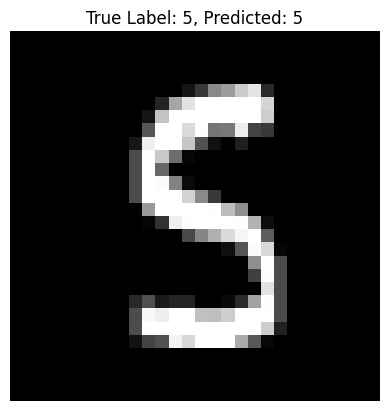

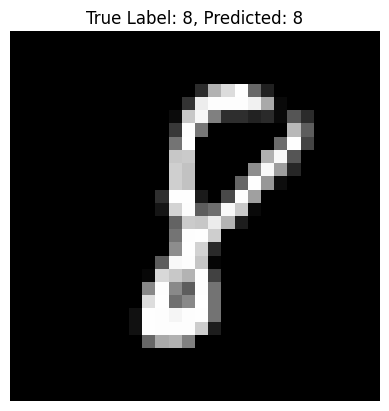

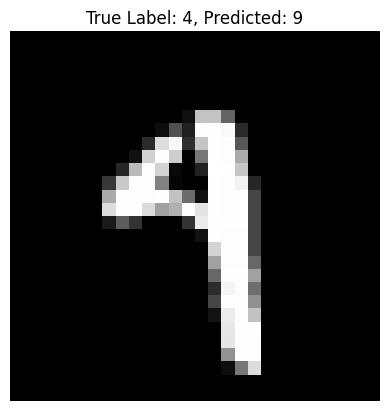

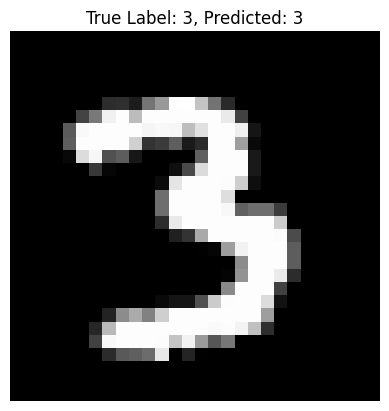

In [ ]:
import matplotlib.pyplot as plt
def visualize_prediction(model, test_images, test_labels, index=0):
    image = test_images[index]
    true_label = test_labels[index]

    predicted_label = np.argmax(model.forward(np.expand_dims(image, axis=0)),axis=1) # Thêm một chiều batch

    plt.imshow(image.squeeze(), cmap='gray')  # .squeeze() để loại bỏ chiều dư thừa
    plt.title(f"True Label: {true_label}, Predicted: {predicted_label[0]}")
    plt.axis('off')  # Tắt trục
    plt.show()
visualize_prediction(cnn,test_images=test_images,test_labels=test_labels,index=240)
visualize_prediction(cnn,test_images=test_images,test_labels=test_labels,index=520)
visualize_prediction(cnn,test_images=test_images,test_labels=test_labels,index=740)
visualize_prediction(cnn,test_images=test_images,test_labels=test_labels,index=500)